# 车牌识别

| 更新时间 | 负责人 | 内容 | 备注 |
| --- | --- | --- | --- |
| 2022年9月23日 | wonder | 初次编写文档 | ---- |

## 准备

- 在 [MaixHub](https://maixhub.com/model/zoo/79) 上获取模型文件和运行源码
- 确认 MaixPy3 版本为 0.5.2 以上
- 使用的硬件为 MaixII-Dock
- 内存卡内是最新版本的镜像系统
- 插卡启动硬件

## 车牌识别


### 部署车牌识别模型

- 该模型采用检测+识别两段任务的方式完成车牌检测，完整模型包含一个检测模型和一个识别模型
- 第一个阶段是该模型借鉴了Retinaface模型结构，从而完成检测图像中车牌位置
- 第二个阶段是采用CTC的方式进行车牌内容识别

将模型读取到 python 环境中，注意下面代码中的 `loc_model_path ` 和 `reg_model_path` 的路径

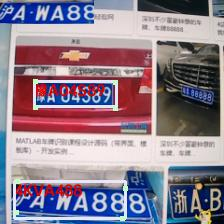


Traceback (most recent call last):
  File "<string>", line unknown, in <module>
Remote.KeyboardInterrupt


In [ ]:
from time import time

class LPR:
    loc_model_path = {
        "param": "/root/app/slim_awnn.param",
        "bin": "/root/app/slim_awnn.bin"
    }
    loc_model_options = {
        "model_type":  "awnn",
        "inputs": {
            "input0": (224, 224, 3)
        },
        "outputs": {
            "output0": (1, 4, 2058),
            "output1": (1, 2, 2058),
            "output2": (1, 8, 2058),
        },
        "mean": [127.5, 127.5, 127.5],
        "norm": [0.0078125, 0.0078125, 0.0078125],
    }
    reg_model_path = {
        "param": "/root/app/lpr_awnn.param",
        "bin": "/root/app/lpr_awnn.bin"
    }
    reg_model_options = {
        "model_type":  "awnn",
        "inputs": {
            "input0": (24, 94, 3)
        },
        "outputs": {
            "output0": (68, 18, 1),
        },
        "mean": [127.5, 127.5, 127.5],
        "norm": [0.0078125, 0.0078125, 0.0078125],
    }

    chars =[ "皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑",
                    "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘" , "粤",
                    "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青" , "宁",
                    "新", "警", "学", "A"  , "B" ,  "C" ,  "D" ,  "E" ,  "F"  ,  "G",
                    "H" ,   "J" ,  "K" ,  "L" , "M" , "N" ,  "P" ,  "Q" ,  "R" , "S",
                    "T" ,  "U" ,  "V" , "W", "X"  , "Y" , "Z" , "0" , "1", "2", "3",
                    "4", "5", "6", "7", "8", "9", "-"]

    variances = [0.1, 0.2]
    steps = [8, 16, 32]
    min_sizes = [12, 24, 48, 96, 192, 320]

    def __init__(self) -> None:
        from maix import nn
        self.loc_model = nn.load(self.loc_model_path , opt = self.loc_model_options)
        self.reg_model = nn.load(self.reg_model_path , opt = self.reg_model_options)

        from maix.nn import decoder
        self.loc_decoder = decoder.license_plate_location([224,224] , self.steps , self.min_sizes, self.variances)
        self.reg_decoder  = decoder.CTC((1,68,18))

    def __del__(self):
        del self.loc_model
        del self.loc_decoder

    def cal_fps(self ,start , end):
        one_second = 1
        one_flash = end - start
        fps = one_second / one_flash
        return  fps

    def  draw_fps(self,img , fps):
        img.draw_string(0, 0 ,'FPS :'+str(fps), scale=1,color=(255, 0, 255), thickness=1)

    def draw_string(self , img , x , y , string , color):
        img.draw_string( x , y , string ,color = color)

    def draw_paste(self , src ,dst):
        src.paste(dst , 0 , 0)

    def draw_rectangle(self,img, box):
        img.draw_rectangle(box[0], box[1], box[2], box[3],color=(230 ,230, 250), thickness=2)

    def draw_point(self,img,landmark):
        for i in range(4):
            x = landmark[2 * i ]
            y = landmark[2 * i + 1]
            img.draw_rectangle(x-2,y-2, x+2,y+2,color= (193 ,255 ,193), thickness =-1)

    def process(self,input):
        loc_out = self.loc_model.forward(input, quantize=1, layout = "chw") # retinaface decoder only support chw layout
        boxes , landmarks = self.loc_decoder.run(loc_out, nms = 0.2 ,score_thresh = 0.7 , outputs_shape =[[1,4,2058],[1,2,2058],[1,8,2058]])

        for i,box in enumerate(boxes):

            landmark = landmarks[i][:6]
            reg_in  = input.crop_affine(landmark , 94 , 24)
            reg_out = self.reg_model.forward(reg_in ,  quantize=1, layout = "chw")

            LP_number = self.reg_decoder.run(reg_out)
            string_LP = ''
            for id in LP_number:
                # string_LP += self.chars[id]
                string_LP += str(id)

            self.draw_string(input , box[0], box[1] , string_LP  ,color=(225,0,0))
            self.draw_paste(input , reg_in)
            self.draw_rectangle(input,box)
            self.draw_point(input , landmarks[i])

def main():
    from maix import display, camera , image
    image.load_freetype("/home/res/sans.ttf")
    app  = LPR()
    while True:
        img = camera.capture().resize(size=(224,224))
        app.process(img)
        display.show(img)
        # break

main()

## 脱机运行

对于 M2Dock，前面说过开机启动代码顺序是 `/root/app/main.py` > `/root/main.py` ，所以在保存的时候自己注意下保存位置